In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import sys
import numpy as np
import pandas as pd
import torchvision
import torch.nn as nn
from tqdm import tqdm, notebook
from PIL import Image, ImageFile
from torch.utils.data import Dataset
from torch import optim, cuda
import torch
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
ImageFile.LOAD_TRUNCATED_IMAGES = True
from timeit import default_timer as timer
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import cv2
import random
from os.path import isfile
import math
import torch.nn.functional as F
import scipy.misc
from skimage.transform import resize
import numpy as np
import gc
import pickle
from sklearn.utils import shuffle

In [2]:
print(torch.cuda.is_available())
if(torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(2020)

In [4]:
learning_rate=1e-5
epochs=100
num_workers=2
batch_size=16
IMG_SIZE    = 256

In [5]:
path= "../input/covid19chestxray/"
def cleanUp(Df):
    Df["Present"]=0
    for idx in Df.index:
        name=Df["Image Name"][idx]
        if(isfile(path+"images/images/"+name)):
            Df["Present"][idx]=1
        else:
            Df["Present"][idx]=0
    Df=Df[Df["Present"]==1]
    return Df

In [6]:
trainDf=pd.read_csv(path+"Train_Combined.csv")
testDf=pd.read_csv(path+"Test_Combined.csv")
trainDf=cleanUp(trainDf)
testDf=cleanUp(testDf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [7]:
trainDf=trainDf.rename(columns={"Image Name":"Path"})

In [8]:
chexpertPath="../input/syde522pjte/CheXpert-v1.0-small/"
trainDf2=pd.read_csv(chexpertPath+"train.csv")
trainDf2=trainDf2[(trainDf2["Frontal/Lateral"]=="Frontal")  & (trainDf2["No Finding"]==1)]
trainDf2=trainDf2.sample(168,replace=False)
trainDf2=trainDf2.reset_index(drop=True)

In [9]:
Df1=trainDf[["Path"]]
Df1["Label"]=1
Df2=trainDf2[["Path"]]
Df2["Label"]=0
Df=Df1.append(Df2)
Df=shuffle(Df)
Df=Df.reset_index(drop=True)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
Covid19Path= "../input/covid19chestxray/images/images/"
chexpertImagePath="../input/syde522pjte/"
def expand_path(p):
    p = str(p)
    if isfile(Covid19Path + p ):
        return (Covid19Path+p)
    if isfile(chexpertImagePath + p):
        return (chexpertImagePath+p)
    return False

In [11]:
traintransforms = transforms.Compose([
                #transforms.Grayscale(num_output_channels=1),
                transforms.Resize((224,224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor()
                ])

testtransforms = transforms.Compose([
                #transforms.Grayscale(num_output_channels=1),
                transforms.Resize((224,224)),
                transforms.ToTensor()
                ])
class CovidDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name=expand_path(self.data.loc[idx, "Path"])
        image=Image.open(img_name)
        image=image.convert('RGB')
        image=self.transform(image)
        label=self.data.loc[idx, "Label"]
        return image,label
    

In [12]:
testDf["Path"]=testDf["Image Name"]
testDf["Label"]=testDf["COVID-19"]
testDf=testDf[["Path","Label"]]

In [13]:
trainSet=CovidDataset(data=Df,transform=traintransforms)
trainLoader=torch.utils.data.DataLoader(trainSet, batch_size=batch_size, num_workers=num_workers)
testSet=CovidDataset(data=testDf,transform=testtransforms)
testLoader=torch.utils.data.DataLoader(testSet, batch_size=batch_size, num_workers=num_workers)

In [14]:
baseModel =torchvision.models.resnext101_32x8d(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [15]:
def train(model,learningRate,dataLoader,cvLoader,n_epochs=2):
        criterion=nn.BCEWithLogitsLoss()
        optimizer=optim.Adam(model.parameters(),lr=learningRate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        save_file_name='covidnetweight.pth'
        max_epochs_stop=5
        print_every=1
        #model.epochs=0
        model=model.to(device)
        ct=0
        for child in model.children():
            if ct < 2:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                for param in child.parameters():
                    param.requires_grad = True
            ct=ct+1
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learningRate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.95)
        epochs_no_improve = 0
        valid_loss_min = np.Inf
        valid_max_acc = 0
        history = []
        try:
            print(f'Model has been trained for: {model.epochs} epochs.\n')
        except:
            model.epochs = 0
            print(f'Starting Training from Scratch.\n')
        overall_start = timer()
        for epoch in (range(n_epochs)):
            # keep track of training and validation loss each epoch
            if(epoch==8):
                for param in model.parameters():
                        param.requires_grad = True 
                optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learningRate,weight_decay=1e-5)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.95)
            train_loss = 0.0
            valid_loss = 0.0

            train_mse = 0
            valid_mse = 0

            # Set to training
            model.train()
            start = timer()

            # Training loop
            for ii, (data, target) in enumerate((dataLoader)):
                target=target.to(device).unsqueeze(1)
                data=data.to(device)
                #target=target.unsqueeze(1)
                # Clear gradients
                optimizer.zero_grad()
                # Predicted outputs are log probabilities
                output = model(data)
                # Loss and backpropagation of gradients
                loss=criterion(output,(target.float()))
                loss.backward()

                # Update the parameters
                optimizer.step()
                # Track train loss by multiplying average loss by number of examples in batch
                train_loss += loss.item() 
                # Calculate accuracy by finding max log probability
                #_, pred = torch.max(output, dim=1)
                #correct_tensor = pred.eq(target.data.view_as(pred))
                # Need to convert correct tensor from int to float to average
                #accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples in batch
                #train_acc += accuracy.item() * data.size(0)

                # Track training progress
                print(
                    f'Epoch: {epoch}\t{100 * (ii + 1) / len(dataLoader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                    end='\r')
            model.epochs += 1
            # After training loops ends, start validation
            if(epoch%2==0):
                    # Don't need to keep track of gradients
                with torch.no_grad():
                    # Set to evaluation mode
                    model.eval()

                    # Validation loop
                    for data, target in cvLoader:
                        # Tensors to gpu
                        target=target.to(device).unsqueeze(1)
                        data = data.to(device)
                        # Forward pass
                        output = model(data)

                        # Validation loss
                        loss=criterion(output,target.float())
                        # Multiply average loss times the number of examples in batch
                        valid_loss += loss.item()
                        # Calculate validation accuracy
                        

                    # Calculate average losses
                    train_loss = train_loss / len(dataLoader)
                    valid_loss = valid_loss / len(cvLoader)

                    # Calculate average accuracy
                    #train_acc = train_acc / len(train_loader.dataset)
                    #valid_acc = valid_acc / len(valid_loader.dataset)

                    history.append([train_loss, valid_loss,scheduler.get_lr()[0],model.epochs])

                    # Print training and validation results
                    if (epoch + 1) % print_every == 0:
                        print(
                            f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                        )
                        print('lr:', scheduler.get_lr()[0])
                        #print(
                        #    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                        #)

                    # Save the model if validation loss decreases
                    if valid_loss < valid_loss_min:
                        # Save model
                        torch.save(model.state_dict(), save_file_name)
                        torch.save(model,"CovidNetModel")
                        # Track improvement
                        epochs_no_improve = 0
                        valid_loss_min = valid_loss
                        best_epoch = epoch

                    # Otherwise increment count of epochs with no improvement
                    else:
                        epochs_no_improve += 1
                        # Trigger early stopping
                        if epochs_no_improve >= max_epochs_stop:
                            print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
                            total_time = timer() - overall_start
                            print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                            # Load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # Attach the optimizer
                            model.optimizer = optimizer

                            # Format history
                            history = pd.DataFrame(history,columns=['train_loss', 'valid_loss','Learning_rate','epochs'])
                            return model,history
            scheduler.step()
        # Attach the optimizer
        model.optimizer = optimizer
        # Record overall time and print out stats
        total_time = timer() - overall_start
        print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} ')
        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')
        # Format history
        history = pd.DataFrame(history,columns=['train_loss', 'valid_loss','Learning_rate','epochs'])
        return model,history
def plotLoss(history):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(history['epochs'],history[c],label=c)
        plt.legend()
        plt.xlabel('no of epochs')
        plt.ylabel('MSE Losses')
        plt.title('Training and Validation Losses')
def saveHistory(fileName,history):
    history.to_pickle(fileName)
def retriveHistory(fileName):
    history=pd.read_pickle(fileName)
    return history

In [16]:
baseModel.fc=nn.Sequential(nn.Linear(2048,out_features=1),nn.Sigmoid())

Starting Training from Scratch.



/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



Epoch: 0 	Training Loss: 0.6387 	Validation Loss: 0.3946
lr: 1e-05
Epoch: 2	100.00% complete. 24.82 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.5154 	Validation Loss: 0.3545
lr: 1e-05
Epoch: 4	100.00% complete. 25.28 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.5093 	Validation Loss: 0.3543
lr: 1e-05
Epoch: 6	100.00% complete. 24.93 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.5076 	Validation Loss: 0.3543
lr: 1e-05
Epoch: 8	100.00% complete. 24.60 seconds elapsed in epoch.
Epoch: 8 	Training Loss: 0.5064 	Validation Loss: 0.3549
lr: 1e-05
Epoch: 10	100.00% complete. 23.93 seconds elapsed in epoch.
Epoch: 10 	Training Loss: 0.5062 	Validation Loss: 0.3549
lr: 1e-05
Epoch: 12	100.00% complete. 23.85 seconds elapsed in epoch.
Epoch: 12 	Training Loss: 0.5060 	Validation Loss: 0.3549
lr: 1e-05
Epoch: 14	100.00% complete. 23.39 seconds elapsed in epoch.
Epoch: 14 	Training Loss: 0.5059 	Validation Loss: 0.3545
lr: 1e-05
Epoch: 16	100.00% complete. 23.48 seconds el

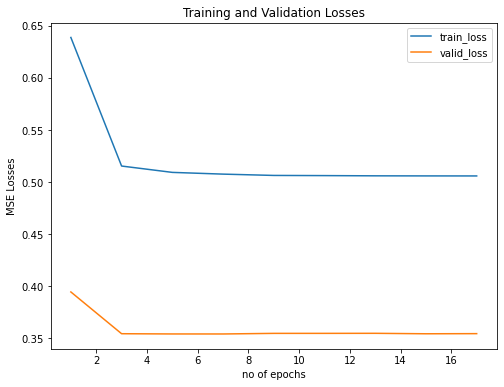

In [17]:
model,history=train(baseModel,1e-5,trainLoader,testLoader,n_epochs=600)
plotLoss(history)

In [18]:
saveHistory("History.pkl",history)

In [19]:
def checkAccuracy(model,cvLoader):
    acc=0
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()

        # Validation loop
        for data, target in cvLoader:
            # Tensors to gpu
            target=target.to(device).unsqueeze(1)
            data = data.to(device)
            # Forward pass
            output = model(data)
            thresh=0.5
            acc+=((output.cpu()>thresh).float()==target.cpu().float()).sum().cpu()
        acc=float(acc)/ len(testLoader.dataset)
        print(acc*100)
        return acc

    

In [20]:
acc=checkAccuracy(baseModel,testLoader)

94.28571428571428
